# KM analysis

## K-means clustering theory

In this notebook, a weather typing clasification is performed using the commonly known K-Means algorithm. With this clustering technique we are able to group the sea-level-pressure data into different related groups, and then associate a storm-surge situation to each of them... All the python code is hosted at `sscode/kma.py`, where we use the scikit-learn package available [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

Regarding the maths... a description of the algorithm can be found at [wikipedia](https://en.wikipedia.org/wiki/K-means_clustering)!! But lets briefly explain the algorithm here:

The KMA clustering technique divides the high-dimensional data space into a number of clusters, each one deﬁned by a prototype and formed by the data for which the prototype is the nearest. Given a database of n-dimensional vectors $X = {x_1, x_2, ..., x_N}$, where $N$ is the total amount of data and $n$ is the dimension of each data $x_k = {x_{1k}, ..., x_{nk}}$, KMA is applied to obtain M groups deﬁned by a prototype or centroid $v_k = {v_{1k}, ..., v_{nk}}$ of the same dimension of the original
data, being $k = 1, ..., M$. The classiﬁcation procedure starts with a random initialization of the centroids ${v_1^0, v_2^0, ..., v_M^0}$. On each iteration $r$, the nearest data to each centroid are identiﬁed and the centroid is redeﬁned as the mean of the corresponding data. For example, on the
$(r + 1)$ step, each data vector $x_i$ is assigned to the jth group, where $j = min{||x_i - v_j^r||, j = 1, ..., M}$, where $||$ deﬁnes the Euclidean distance and $v_j^r$
are the centroids on the $r$ step. The centroid is updated as:

$$
\boxed{
v_j^{r+1} = \sum_{x_i\epsilon C_j} \frac{x_i}{n_j}
}
$$

where $n_j$ is the number of elements in the jth group and $C_j$ is the subset of data included in group $j$. The KMA iteratively moves the centroids minimizing the overall within-cluster distance until it converges and data belonging to every group are stabilized.

```{figure} ../media/images/k-means.png
---
width: 550px
name: kma
---
Performance of the k-means algorithm over a random dataset. It is important to highlight that the kma technique is just able to linearly separate the data ([image reference](https://scikit-learn.org/stable/_images/sphx_glr_plot_kmeans_digits_001.png))
```

In [1]:
# basics
import os, sys
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import plotly.express as px

# append sscode to path
sys.path.insert(0, '/Users/administrador/Documents/geocean-nz-ss')
data_path = '/Volumes/ToshibaJT/geocean-nz-ss/data'
os.environ["SSURGE_DATA_PATH"] = data_path

# custom
from sscode.data import Loader, load_moana_hindcast_ss, load_dac_hindcast, \
    join_load_uhslc_tgs, load_moana_hindcast
from sscode.kma import KMA_simple
from sscode.config import default_region_reduced, default_region
from sscode.plotting.config import _figsize
from sscode.plotting.utils import plot_ccrs_nz, custom_cmap, colors_dwt
from sscode.plotting.pca import plot_pcs

# warnings
import warnings
warnings.filterwarnings('ignore')

DATA PATH /Volumes/ToshibaJT/geocean-nz-ss/data


## Load and plot some data + PCs

As always, we load the data, both the storm surge and the PCs (regional PCs in this case), and then plot whatever we want to!!

In [2]:
# load the data from pre-saved files
load_cfsr_moana_uhslc = Loader(
    load_predictor_files=(
        True,[data_path+'/cfsr/CFSR_MSLP_daily.nc',data_path+'/cfsr/CFSR_WINDs_daily.nc']
    ), plot=(False,False,False)
)
ss_grid_sites = xr.open_dataset(
    '../data/storm_surge_data/moana_hindcast_v2/ss_grid_300m_depth_daily.nc')


 loading previously saved atmospheric data from ['/Volumes/ToshibaJT/geocean-nz-ss/data/cfsr/CFSR_MSLP_daily.nc', '/Volumes/ToshibaJT/geocean-nz-ss/data/cfsr/CFSR_WINDs_daily.nc'] 


 loading the UHSLC tidal guages... 




 plotting 4 components with 9 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



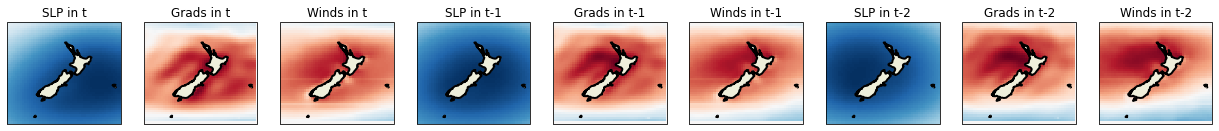

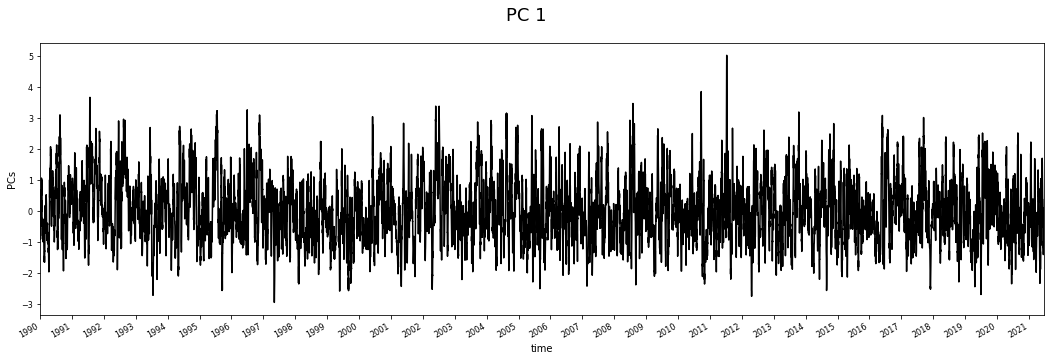

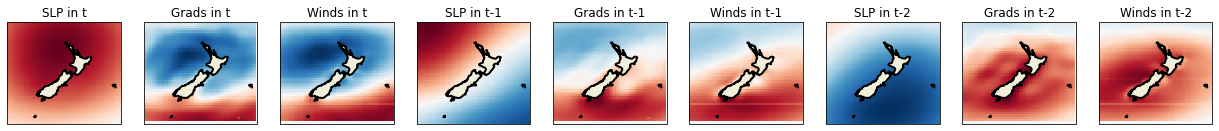

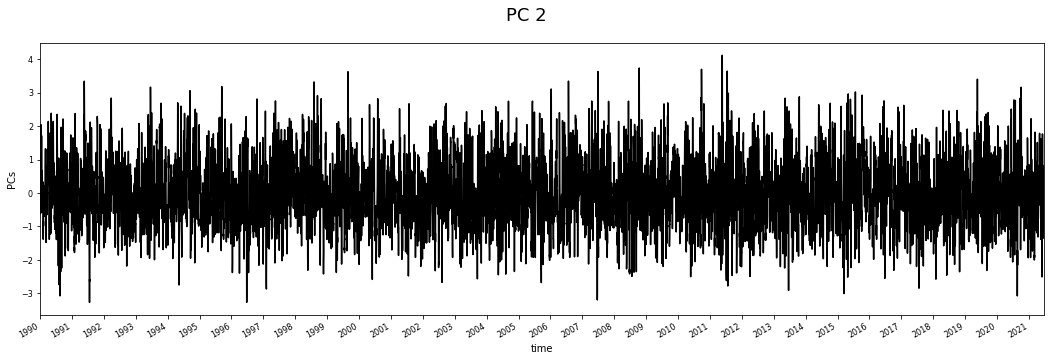

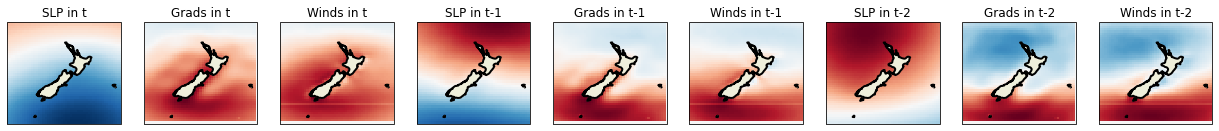

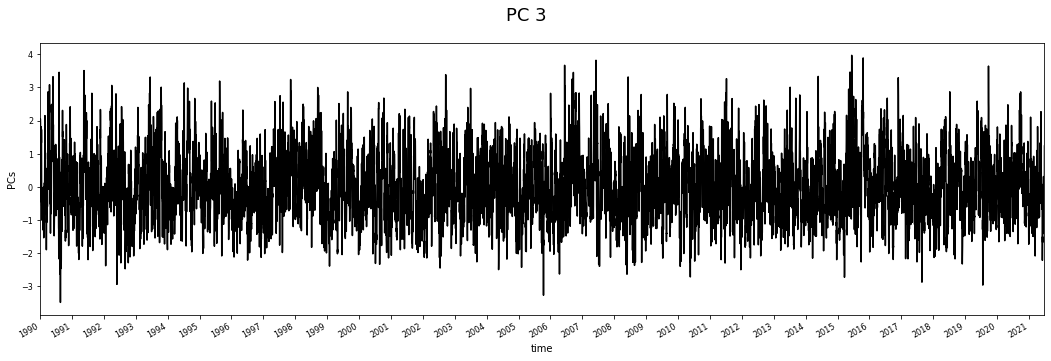

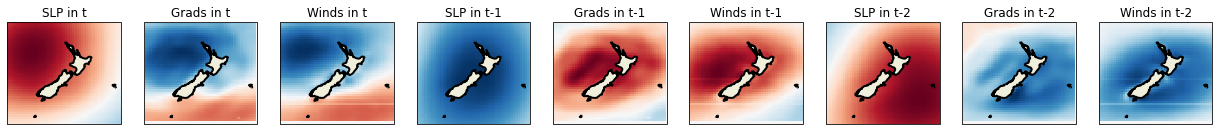

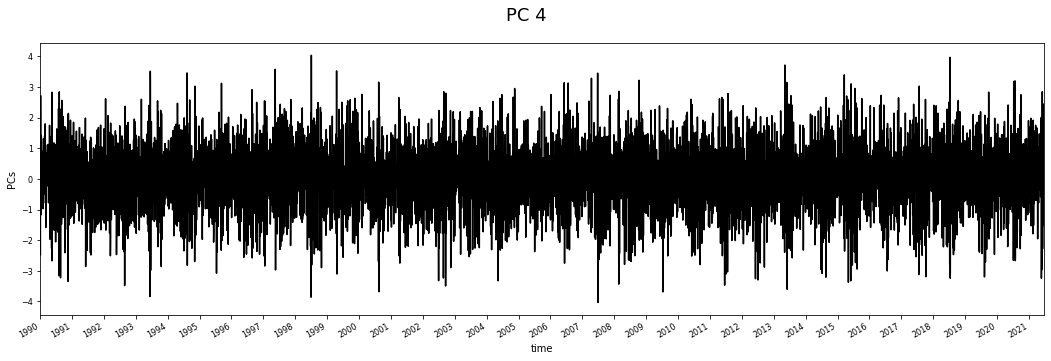

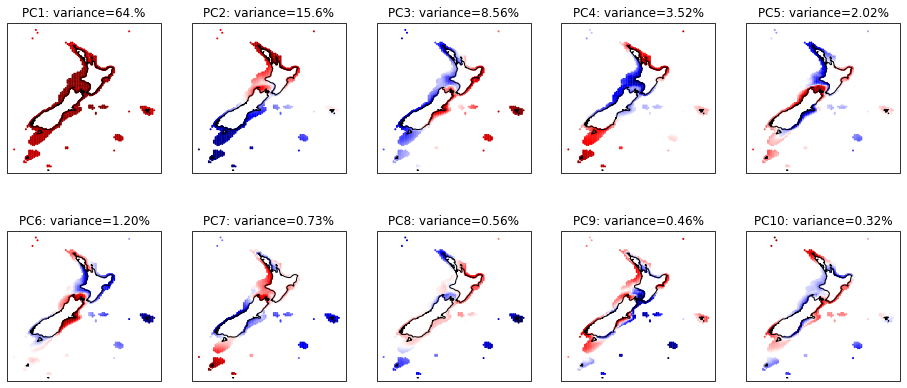

In [3]:
# load / calculate the regional pcs
pcs_cfsr = xr.open_dataset('../data/cfsr/default_region_reduced_None_winds_gradients_1D_tl3.nc')
plot_pcs(pcs_cfsr,n_plot=4,region=default_region_reduced,
         pca_ttls=['SLP in t','Grads in t','Winds in t',
                   'SLP in t-1','Grads in t-1','Winds in t-1',
                   'SLP in t-2','Grads in t-2','Winds in t-2'])
ss_pcs = xr.open_dataset('../data/storm_surge_data/regional_ONE_shore_ss_pcs.nc')
fig, axes = plt.subplots(ncols=5,nrows=2,figsize=(16,7),
                         subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
for i,ax in enumerate(axes.flatten()):
    pc_plot = (ss_pcs.EOFs/np.sqrt(ss_pcs.variance)).isel(n_components=i).values
    th_value = max(abs(np.max(pc_plot)),abs(np.min(pc_plot)))
    p = ax.scatter(ss_pcs.lon.values,ss_pcs.lat.values,
                   c=pc_plot,vmin=-th_value,vmax=+th_value,
                   cmap='seismic',s=1,transform=ccrs.PlateCarree())
    expl_var = np.cumsum(ss_pcs.variance.values)/np.sum(ss_pcs.variance.values)*100
    var_ttl = str(expl_var[i])[:3] if i==0 else str(expl_var[i]-expl_var[i-1])[:4]
    ax.set_title(f'PC{i+1}: variance={var_ttl}%')
for ax in axes.flat:
    ax.coastlines()

In [4]:
np.cumsum(pcs_cfsr.variance.values)/pcs_cfsr.total_variance.values

array([0.1277436 , 0.21200389, 0.27855168, 0.33437853, 0.37521705,
       0.4140625 , 0.44427278, 0.47094393, 0.49618042, 0.52036663,
       0.54178857, 0.5608859 , 0.57968865, 0.59547352, 0.61093356,
       0.62593095, 0.64039856, 0.6531998 , 0.66302639, 0.67257951,
       0.68192261, 0.69105795, 0.69954512, 0.70793998, 0.71625091,
       0.72373863, 0.73063423, 0.73738825, 0.74400999, 0.7500547 ,
       0.75599721, 0.76157163, 0.76686782, 0.77187861, 0.77686754,
       0.78152769, 0.78597601, 0.79012685, 0.79417365, 0.7981854 ,
       0.80180548, 0.80523538, 0.80861239, 0.81184249, 0.81500151,
       0.81809421, 0.82110186, 0.82402104, 0.82690812, 0.82978341,
       0.83238343, 0.834904  , 0.8373989 , 0.83984254, 0.84214314,
       0.84441047, 0.84646087, 0.84848142, 0.85045345, 0.85237743,
       0.85429617, 0.85620176, 0.85807472, 0.85991234, 0.86166707,
       0.86335231, 0.86500145, 0.86662001, 0.86823112, 0.86979351,
       0.87128933, 0.87277933, 0.87423997, 0.87569785, 0.87715

### Plot mean SLP and SS circumstances

As we are trying to represent all the different climate situations, we will now plot how the mean SLP and SS circumstances might look like in the area around New Zealand.

## Calculate the weather types

add extra info regarding weather types!!


 loading the Moana v2 hindcast data (ss)... 



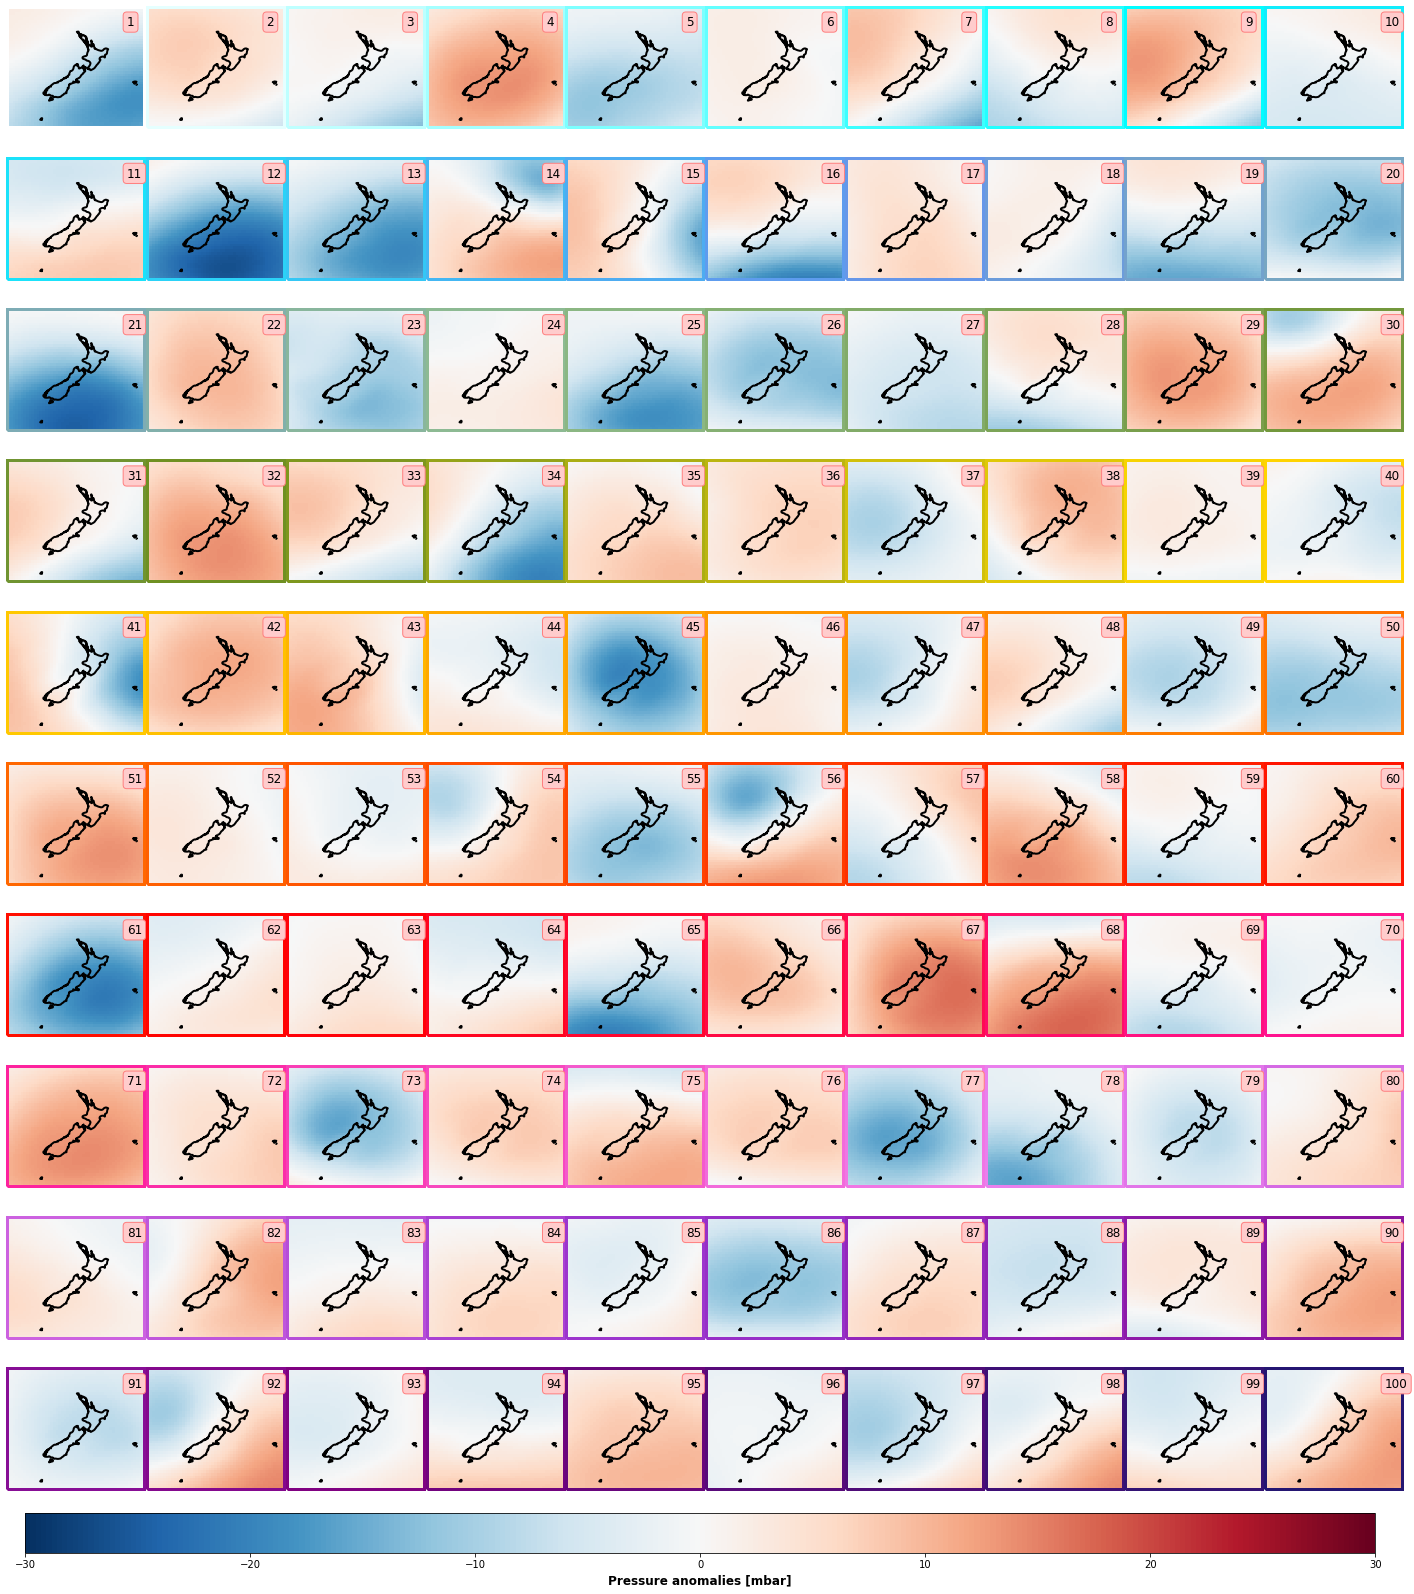

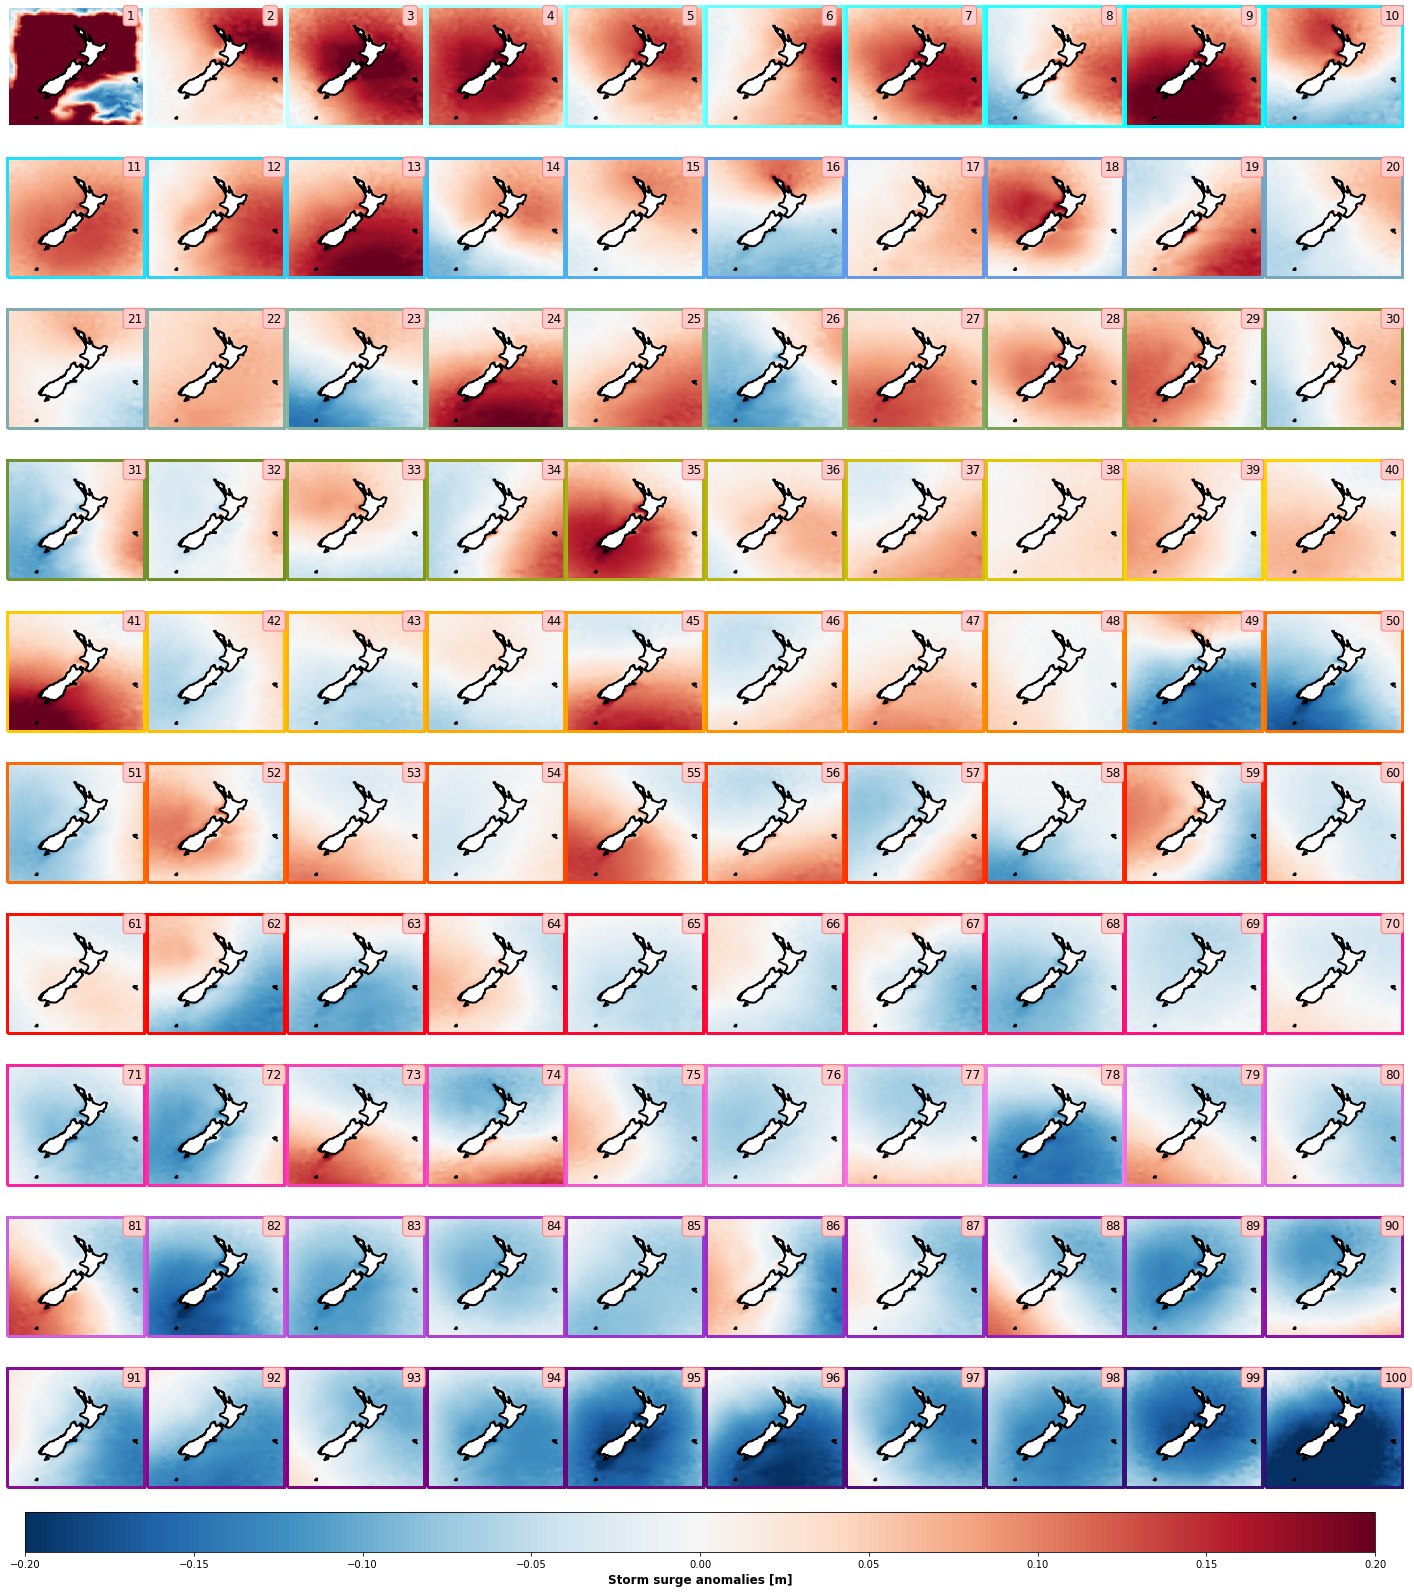

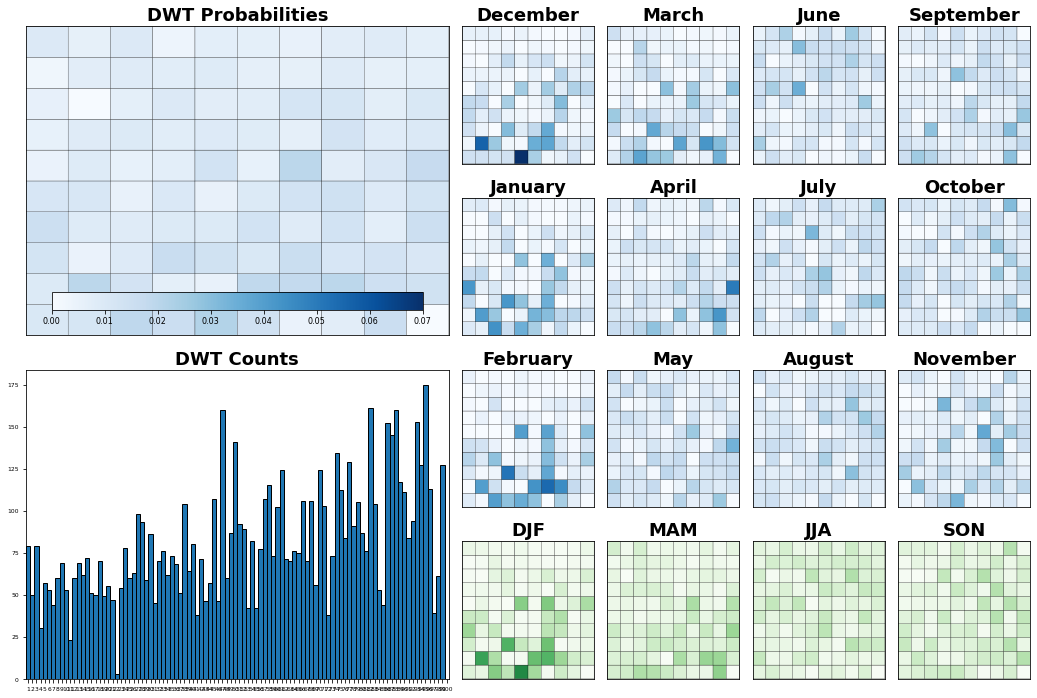

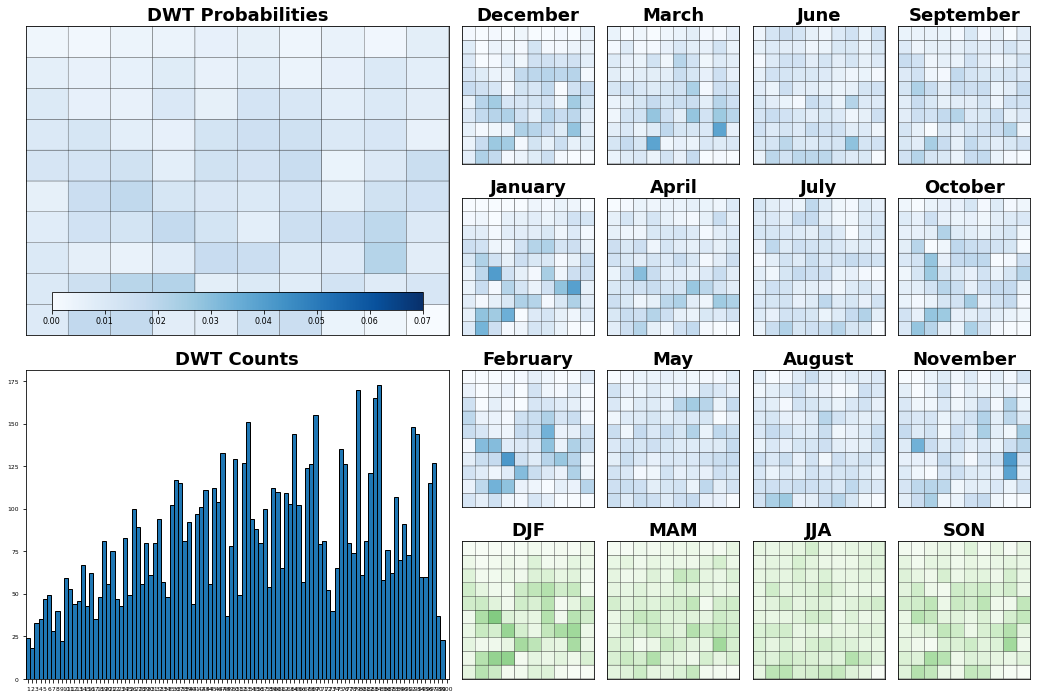

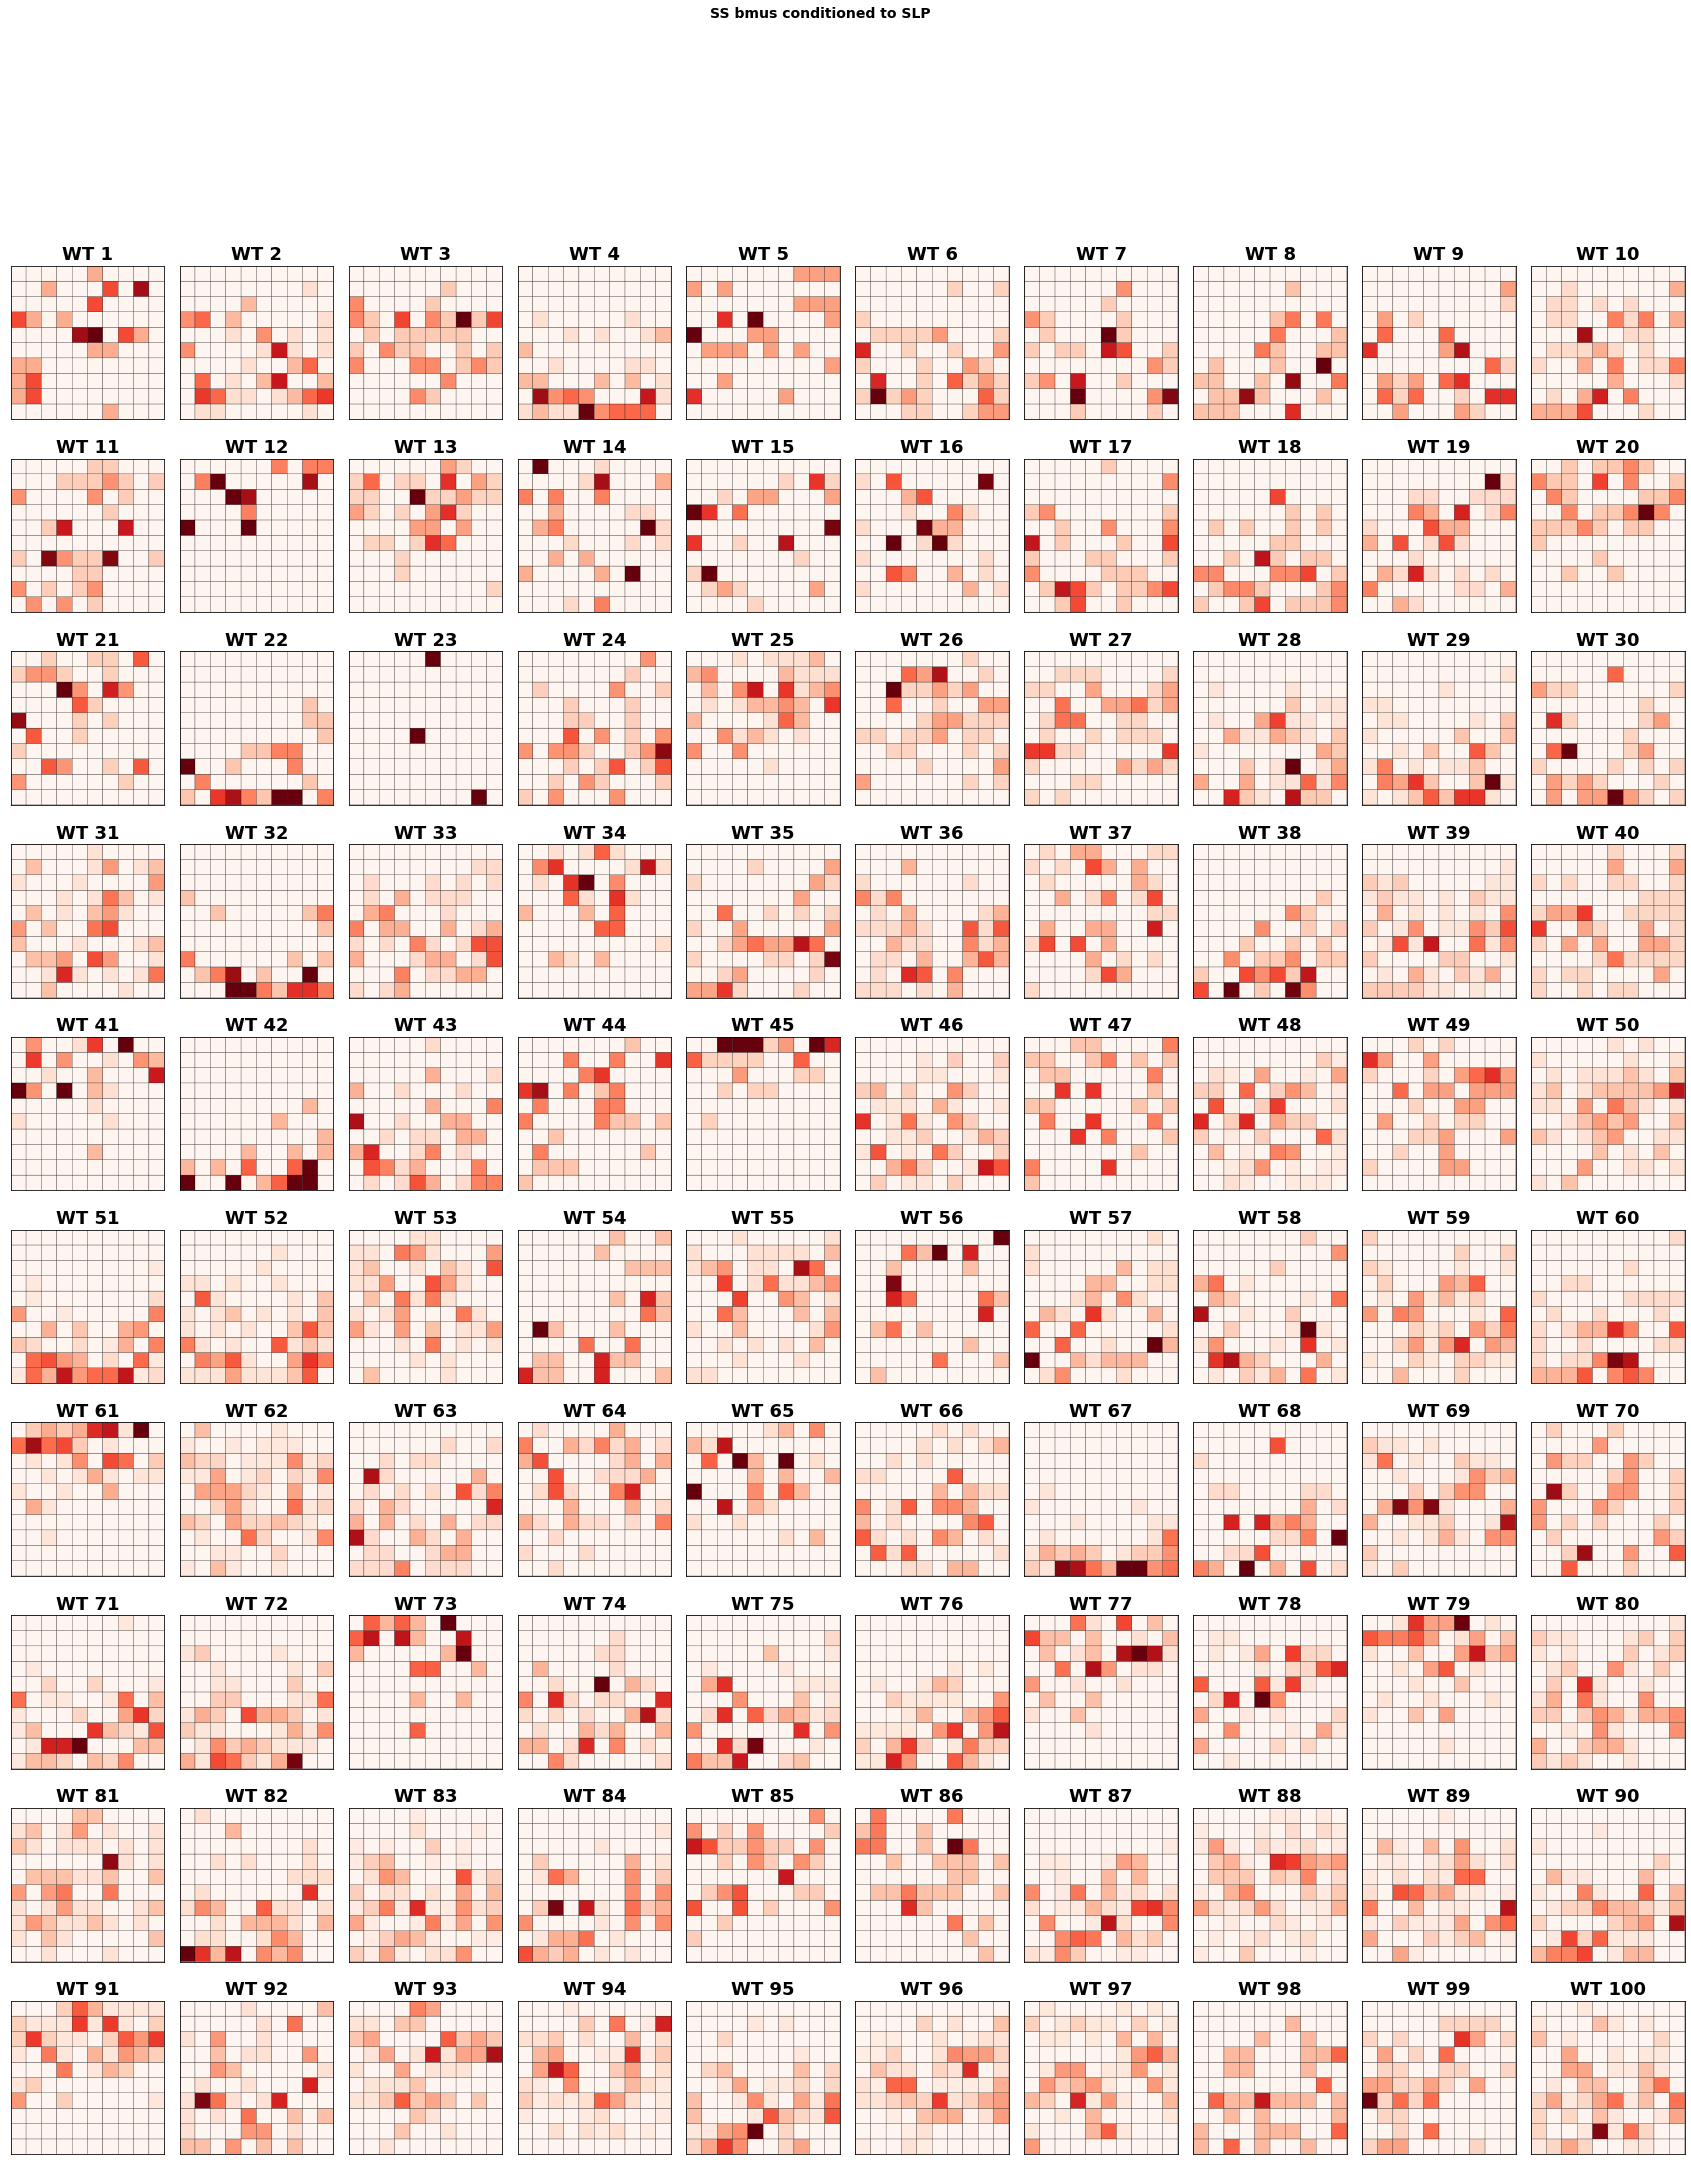

In [5]:
# lets calculate the weather types
run = True
if run:
    kms_data = KMA_simple(
        load_cfsr_moana_uhslc.predictor_slp.SLP.sel(
            longitude=slice(default_region_reduced[0],default_region_reduced[1]),
            latitude=slice(default_region_reduced[2],default_region_reduced[3])
        ), load_moana_hindcast_ss(daily=True), ss_grid_sites,
        pcs_cfsr, ss_pcs, plot=True,
        n_clusters=100, calculate_gev_stats=False
    )

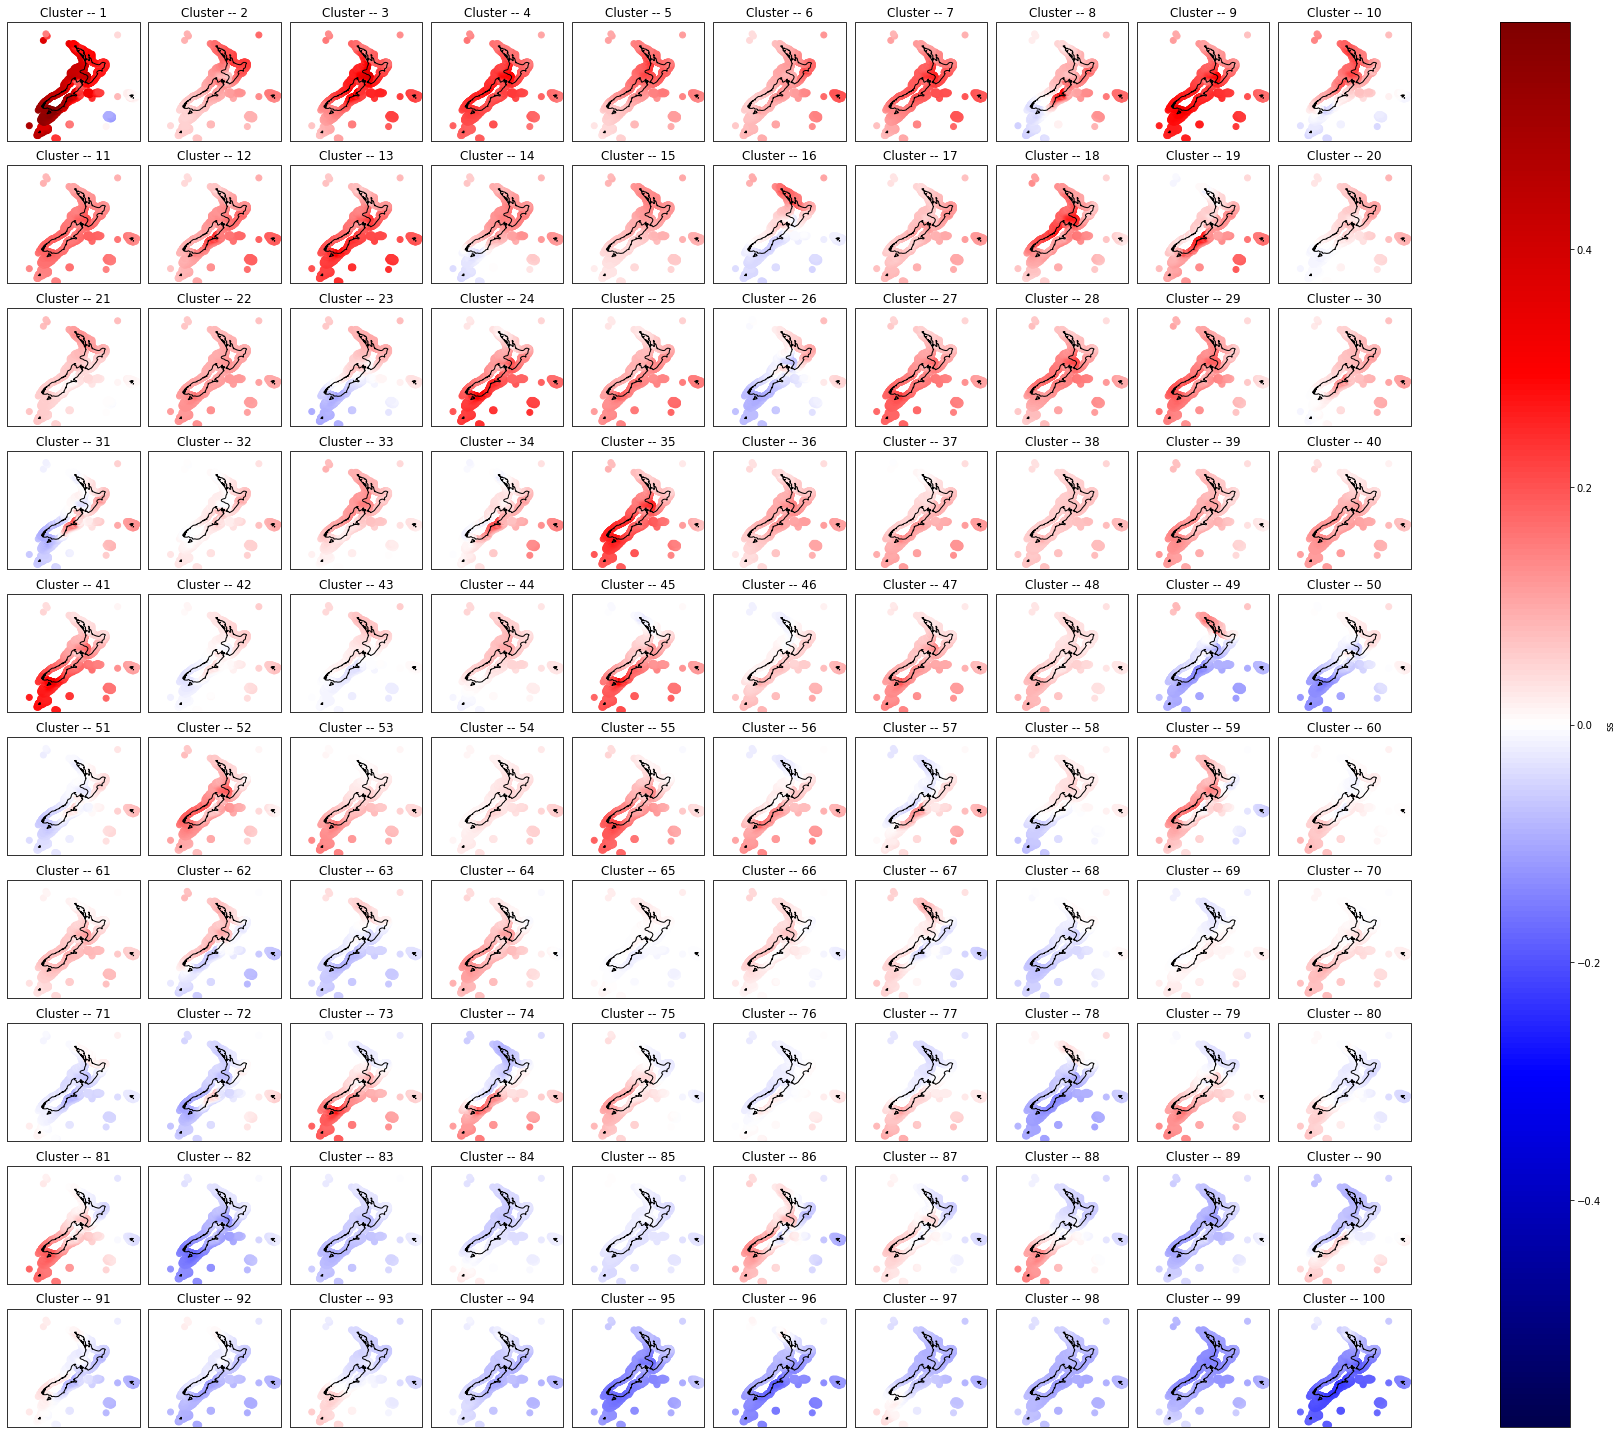

In [6]:
p = kms_data[1].plot.scatter(
    x='lon',y='lat',hue='ss',col='n_clusters',col_wrap=10,cmap='seismic',
    subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
    transform=ccrs.PlateCarree(),figsize=(25,20))
for i,ax in enumerate(p.axes.flat):
    ax.coastlines()
    ax.set_extent(default_region_reduced)
    ax.set_title(f'Cluster -- {i+1}')

## GEV analysis (by cluster)

For each cluster, we took the daily maxima and perform a GEV analysis, which code can be found [here](https://github.com/javitausia/geocean-nz-ss/blob/main/sscode/statistical.py). 

To refresh our memories, this probability density function is usually used to statistically represent the distribution of extreme events (in this case, daily maxima), where the equation can take the following aspects:

$$
\boxed{
f(x)=\left\{\begin{matrix}
\exp\left [ -\left ( 1+\xi \frac{x^{(r)}-\mu}{\psi}{} \right )^{-\frac{1}{\xi}}_+ \right ] \cdot \prod_{k=1}^{r}\psi ^{-1}\exp \left ( -\frac{x^{(k)}-\mu}{\psi} \right )^{-1-\frac{1}{\xi}}_+ & \textrm{for } \xi\neq 0 \\ 
\exp\left [- \exp \left ( -\xi \frac{x^{(r)}-\mu}{\psi}{} \right ) \right ] \cdot \prod_{k=1}^{r}\psi ^{-1}\exp \left ( -\frac{x^{(k)}-\mu}{\psi} \right )
 & \textrm{for } \xi =  0
\end{matrix}\right.
}
$$

where $(a)_+ = max(0,a)$ and $\mu$ , $\psi$ y $\xi$ are the parameters of the GEV distribution. This parameters are estimated using the maximum likelihood estimation, which consists in finding the optimal parameters that maximizes the logarithm of the likelihood for the data:

$$
\boxed{
\theta^{\textrm{ opt}}=\underset{\theta}{\textrm{arg max }}L(\theta)
}
$$

more information can be found [here](https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution)!!

AttributeError: 'Dataset' object has no attribute 'mu'

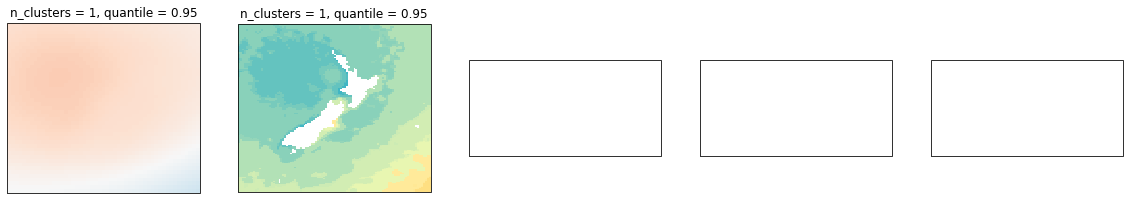

In [7]:
from sscode.plotting.kma import plot_cluster_wgev
plot_cluster_wgev(kms_data[0],kms_data[1],[1,31])

```{tip}
Images generated by code, as the one above, can be easily open in a new window, as they have all been generated with good quality for this particular purpose!!
```

## Extras..

### Calculate prediction errors (not the goal)

In [ ]:
# check predictions with the kmeans_algo==weather_types
p = np.abs(load_moana_hindcast_ss(daily=True).sel(time=kms_data[0].test_time) - \
    kms_data[0].ss_clusters_mean.sel(n_clusters=kms_data[0].bmus_pred.values).values)\
    .groupby('time.season').mean().plot(
        col='season',vmin=0.0,vmax=0.1,cmap='jet',figsize=(20,4),
        subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
        transform=ccrs.PlateCarree()
)
plot_ccrs_nz(p.axes.flatten(),plot_labels=(False,None,None))

### Perform analysis in south-west coast

here goes extra info for the GEV... deleted... saved locally...